# Text Analysis on Great Expectations Novel

### Imports- **Run First**

In [1]:
#Bring in text file with our novel
textfile = open('great_expectations.txt', 'r', encoding = "utf8")
great_expect = textfile.read()

print(great_expect)

The Project Gutenberg eBook of Great Expectations, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Great Expectations

Author: Charles Dickens

Release Date: July, 1998 [eBook #1400]
[Most recently updated: April 27, 2020]

Language: English

Character set encoding: UTF-8

Produced by: An Anonymous Volunteer and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***

[Illustration]




Great Expectations

[1867 Edition]

by Charles Dickens


Contents

 Chapter I.
 Chapter II.
 Chapter III.
 Chapter IV.
 Chapter V.
 Chapter VI.
 Chapter VII.
 Chapte

In [2]:
#Import libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

import pandas as pd
from PIL import Image
import numpy as np
import random
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Data cleaning to split data into sentences
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"

text = " " + great_expect + "  "
text = text.replace("\n"," ")
text = re.sub(prefixes,"\\1<prd>",text)
text = re.sub(websites,"<prd>\\1",text)
text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
if "..." in text: text = text.replace("...","<prd><prd><prd>")
if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
if "”" in text: text = text.replace(".”","”.")
if "\"" in text: text = text.replace(".\"","\".")
if "!" in text: text = text.replace("!\"","\"!")
if "?" in text: text = text.replace("?\"","\"?")
text = text.replace(".",".<stop>")
text = text.replace("?","?<stop>")
text = text.replace("!","!<stop>")
text = text.replace("<prd>",".")
sentences = text.split("<stop>")
sentences = [s.strip() for s in sentences]
sentences = pd.DataFrame(sentences)
sentences.columns = ['sentence']

In [4]:
#Remove the first few rows of text that are irrelevant for analysis
sentences.drop(sentences.index[:59], inplace=True)
sentences = sentences.reset_index(drop=True)
sentences.head(10)

sentence
0  [Illustration]     Chapter I.   My father’s fa...
1  So, I called myself Pip, and came to be called...
2  I give Pirrip as my father’s family name, on t...
3  As I never saw my father or my mother, and nev...
4  The shape of the letters on my father’s, gave ...
5  From the character and turn of the inscription...
6  To five little stone lozenges, each about a fo...
7  Ours was the marsh country, down by the river,...
8  My first most vivid and broad impression of th...
9  At such a time I found out for certain that th...

### How to perform Vader sentiment analysis

In [5]:
#Initialize Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [6]:
#Perfom Vader sentiment analysis
sentences['compound'] = [analyzer.polarity_scores(x)['compound'] for x in sentences['sentence']]
sentences['neg'] = [analyzer.polarity_scores(x)['neg'] for x in sentences['sentence']]
sentences['neu'] = [analyzer.polarity_scores(x)['neu'] for x in sentences['sentence']]
sentences['pos'] = [analyzer.polarity_scores(x)['pos'] for x in sentences['sentence']]
sentences.head(10)

sentence  compound    neg    neu   
0  [Illustration]     Chapter I.   My father’s fa...    0.0000  0.000  1.000  \
1  So, I called myself Pip, and came to be called...    0.0000  0.000  1.000   
2  I give Pirrip as my father’s family name, on t...    0.0772  0.000  0.942   
3  As I never saw my father or my mother, and nev...    0.3612  0.000  0.941   
4  The shape of the letters on my father’s, gave ...   -0.1531  0.088  0.846   
5  From the character and turn of the inscription...   -0.2960  0.087  0.913   
6  To five little stone lozenges, each about a fo...    0.4404  0.047  0.883   
7  Ours was the marsh country, down by the river,...    0.0000  0.000  1.000   
8  My first most vivid and broad impression of th...    0.5423  0.000  0.836   
9  At such a time I found out for certain that th...   -0.9325  0.124  0.848   

     pos  
0  0.000  
1  0.000  
2  0.058  
3  0.059  
4  0.065  
5  0.000  
6  0.070  
7  0.000  
8  0.164  
9  0.028

In [7]:
#Get number of positive, neutral, and negative sentences
positive_sentence = sentences.loc[sentences['compound'] > 0]
negative_sentence = sentences.loc[sentences['compound'] < 0] 
neutral_sentence = sentences.loc[sentences['compound'] == 0]

print(sentences.shape)
print(len(positive_sentence))
print(len(negative_sentence))
print(len(neutral_sentence))

(9979, 5)
3232
2452
4295


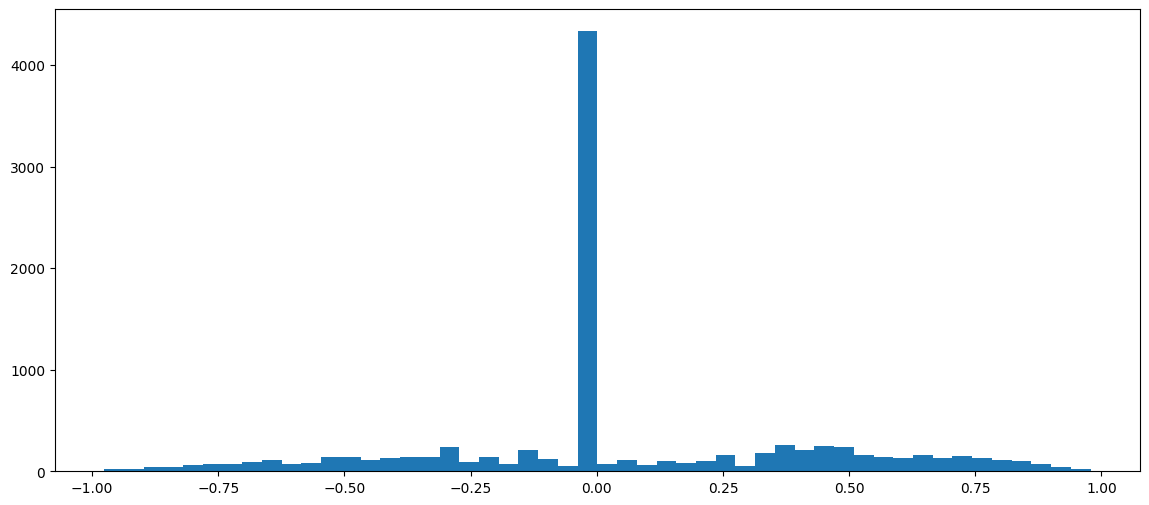

In [8]:
#Visualize Vader sentiment results
plt.figure(figsize=(14,6))
plt.hist(sentences['compound'], bins=50);